# Coregister DEMs collected over Flask Glacier
The polar geospacial center suppled us with digital elevation models (DEMs) of the Flask Glacier area. Four of them were collected during the 2024-25 melt season. 

This notebook uses pdem_tools to coregister them using the assumption that they should be identical over bedrock areas. 

This workflow is based on the tutorial [here](https://pdemtools.readthedocs.io/en/latest/examples/coregistration.html) with some modification to how we get a rock mask: we use a shpafile from Quantarctica instead a mask from bedmachine. 

In [1]:
import os
import numpy as np
import sys
import os
sys.path.append('/Users/jkingslake/Documents/science/pdemtools/src')
import pdemtools as pdt
import xarray as xr
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Arial"
import rioxarray as rxr
from scipy.ndimage import binary_erosion



## Load two dems
Load the DEMs while also supplying a bitmask which contains informaiton on which pixels considered reliable. `pdt.load.from_fpath` uses this bitmask to mask out anything that is not relable. 

Also extract the dates of the DEMs. 

In [2]:
dem_dir = "../../../remote sensing/worldview/6158_2025apr22_Kingslake_2024_25_DEMs/dem/"
vnumber = '_v040316'
SETM_prefix = 'SETSM_s2s041_'

dem_name = 'WV02_20250102_103001010BAF5D00_103001010C7CFB00_2m'
dem_1_fpath = os.path.join(dem_dir, dem_name + vnumber, SETM_prefix + dem_name + '_seg1_dem.tif')
bitmask_1_fpath = os.path.join(dem_dir, dem_name + vnumber, SETM_prefix + dem_name + '_seg1_bitmask.tif')
dem_1 = pdt.load.from_fpath(dem_1_fpath,  bitmask_fpath=bitmask_1_fpath, chunks=True)

dem_name = 'WV03_20250125_10400100A1848B00_10400100A1BD5000_2m'
bitmask_2_fpath = os.path.join(dem_dir, dem_name + vnumber, SETM_prefix + dem_name + '_seg1_bitmask.tif')
dem_2_fpath = os.path.join(dem_dir, dem_name + vnumber, SETM_prefix + dem_name + '_seg1_dem.tif')
dem_2 = pdt.load.from_fpath(dem_2_fpath, bitmask_fpath=bitmask_2_fpath, chunks=True)

def get_date(fn):
    # get the filename without the extension
    filename = os.path.basename(fn)
    # split the filename into parts
    parts = filename.split('_')
    # get the date part (the 4th part in this case)
    date_part = parts[3]
    # format the date part as YYYYMMDD
    date = f"{date_part[:4]}-{date_part[4:6]}-{date_part[6:]}"
    return date

date_1 = get_date(dem_1_fpath)
date_2 = get_date(dem_2_fpath)

In [3]:
dem_2

<xarray.DataArray (y: 10088, x: 9096)> Size: 367MB
dask.array<getitem, shape=(10088, 9096), dtype=float32, chunksize=(5632, 5632), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 73kB -2.38e+06 -2.38e+06 ... -2.361e+06 -2.361e+06
  * y            (y) float64 81kB 1.237e+06 1.237e+06 ... 1.217e+06 1.217e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        974.703125
    STATISTICS_MEAN:           508.94655599621
    STATISTICS_MINIMUM:        325.5390625
    STATISTICS_STDDEV:         166.13771450731
    STATISTICS_VALID_PERCENT:  51.41
    _FillValue:                -9999.0
    scale_factor:              1.0
    add_offset:                0.0

In [5]:
date_1, date_2

('2025-01-02', '2025-01-25')

Text(0.5, 1.0, '2025-01-25')

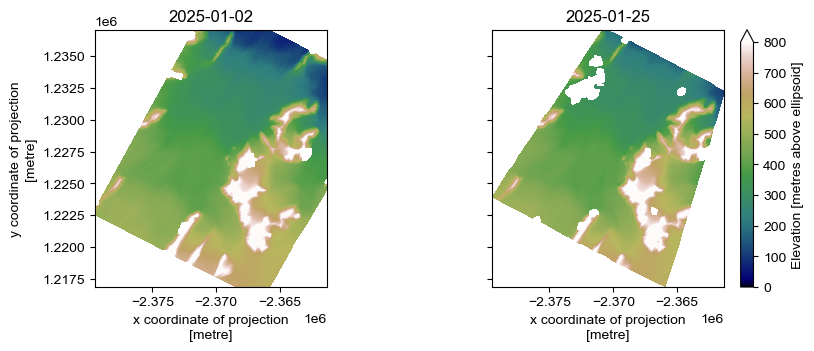

In [8]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,3.4))
ax = axes[0]
dem_1.plot.imshow(ax=ax, cmap='gist_earth', vmin=0, vmax=800, add_colorbar=False)
ax.set_aspect('equal')
ax.set_title(date_1)

ax=axes[1]
dem_2.plot.imshow(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'Elevation [metres above ellipsoid]'})
ax.set_aspect('equal')
ax.set_ylabel(None)
ax.set_title(date_2)

## Compute the difference between the dems without coregistering them. 
This is done for two reasons:
1. To compare the result of differencing wihtout and (later) with coregistration.
2. To get the bounds of the overlap between the two DEMs. 

In [10]:
dz_no_coreg = dem_2 - dem_1
bounds = dz_no_coreg.rio.bounds()

dz_no_coreg.shape, dem_2.shape, dem_1.shape

((10088, 9096), (10088, 9096), (11800, 11308))

## Reload the two DEMS, this time defining the bounds of the overlap.
WIth pad = True, this makes sure both loaded DEMs have the same shape.

In [37]:
dem_1 = pdt.load.from_fpath(dem_1_fpath, bounds=bounds, pad=True, bitmask_fpath=bitmask_1_fpath)
dem_2 = pdt.load.from_fpath(dem_2_fpath, bounds=bounds, pad=True, bitmask_fpath=bitmask_2_fpath)
dem_1


<xarray.DataArray (y: 10088, x: 9096)> Size: 367MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(10088, 9096), dtype=float32)
Coordinates:
  * x            (x) float64 73kB -2.38e+06 -2.38e+06 ... -2.361e+06 -2.361e+06
  * y            (y) float64 81kB 1.237e+06 1.237e+06 ... 1.217e+06 1.217e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        998.484375
    STATISTICS_MEAN:           432.02344391351
    STATISTICS_MINIMUM:        301.921875
    STATISTICS_STDDEV:         134.63725094011
    STATISTICS_VALID_PERCENT:  47.28
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                -9999.0

Text(0.5, 1.0, 'dem_2 padded')

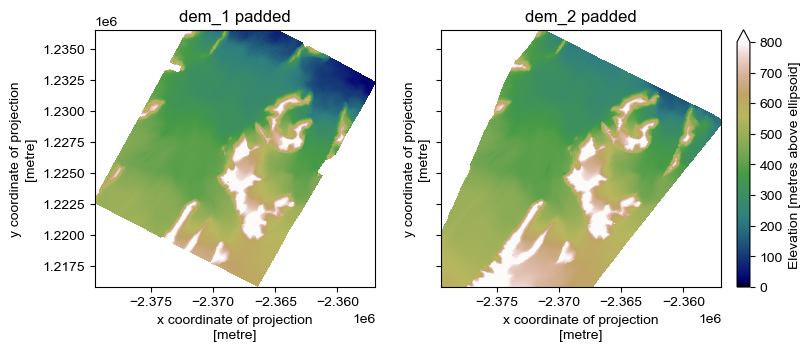

In [ ]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,3.4))
ax = axes[0]
dem_1.plot.imshow(ax=ax, cmap='gist_earth', vmin=0, vmax=800, add_colorbar=False)
ax.set_aspect('equal')
ax.set_title('dem_1 padded')

ax=axes[1]
dem_2.plot.imshow(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'Elevation [metres above ellipsoid]'})
ax.set_aspect('equal')
ax.set_ylabel(None)
ax.set_title('dem_2 padded')

Double check that they have the same bounds

In [39]:
dem_1.rio.bounds()==dem_2.rio.bounds()

True

## Create a mask of the rock area using a shapefile from Quantarctica

In [40]:
bedrock_mask=pdt.data.bedrock_mask_from_vector('/Users/jkingslake/Documents/data/quantarctica/Quantarctica3/Geology/ADD/ADD_RockOutcrops_Landsat8.shp', dem_1)
bedrock_mask

<xarray.DataArray (y: 10088, x: 9096)> Size: 367MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(10088, 9096), dtype=float32)
Coordinates:
  * x            (x) float64 73kB -2.38e+06 -2.38e+06 ... -2.361e+06 -2.361e+06
  * y            (y) float64 81kB 1.237e+06 1.237e+06 ... 1.217e+06 1.217e+06
    spatial_ref  int64 8B 0

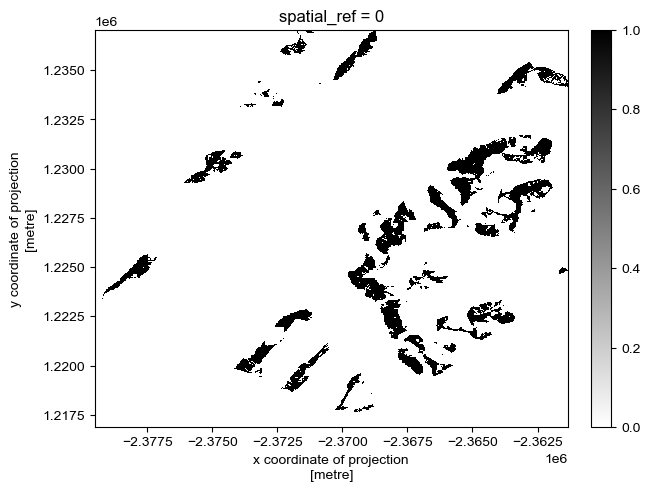

In [41]:
bedrock_mask.plot.imshow(cmap="gray_r")

## Coregister the second DEM to the first

In [42]:
dem_2_coreg_bedrock, metadata_coreg_bedrock = dem_2.pdt.coregister_dems(
    dem_1,
    stable_mask=bedrock_mask,
    return_stats=True,
)

Planimetric Correction Iteration 1
Offset (z,x,y): 0.000, 0.000, 0.000
RMSE = 6.250551223754883
Planimetric Correction Iteration 2
Offset (z,x,y): 2.573, 1.482, 2.159
Translating: 2.57 Z, 1.48 X, 2.16 Y
RMSE = 5.513979434967041
Planimetric Correction Iteration 3
Offset (z,x,y): 2.692, 1.872, 2.567
Translating: 2.69 Z, 1.87 X, 2.57 Y
RMSE = 5.504906177520752
Planimetric Correction Iteration 4
Offset (z,x,y): 2.720, 1.950, 2.641
Translating: 2.72 Z, 1.95 X, 2.64 Y
RMSE = 5.506061553955078
RMSE step in this iteration (0.00116) is above threshold (-0.001), stopping and returning values of prior iteration.
Final offset (z,x,y): 2.692, 1.872, 2.567
Final RMSE = 5.504906177520752


In [43]:
metadata_coreg_bedrock

{'coreg_status': 'coregistered',
 'x_offset': 1.8717942535877228,
 'y_offset': 2.567154824733734,
 'z_offset': 2.691531077027321,
 'x_offset_err': 0.006405781185745701,
 'y_offset_err': 0.006135186483335787,
 'z_offset_err': 0.003900718495579988,
 'rmse': 5.504906177520752,
 'coregistration_type': 'reference_dem'}

## Compute the difference between the coregistered DEMs and the non-coregistered DEMs
...and plot them.

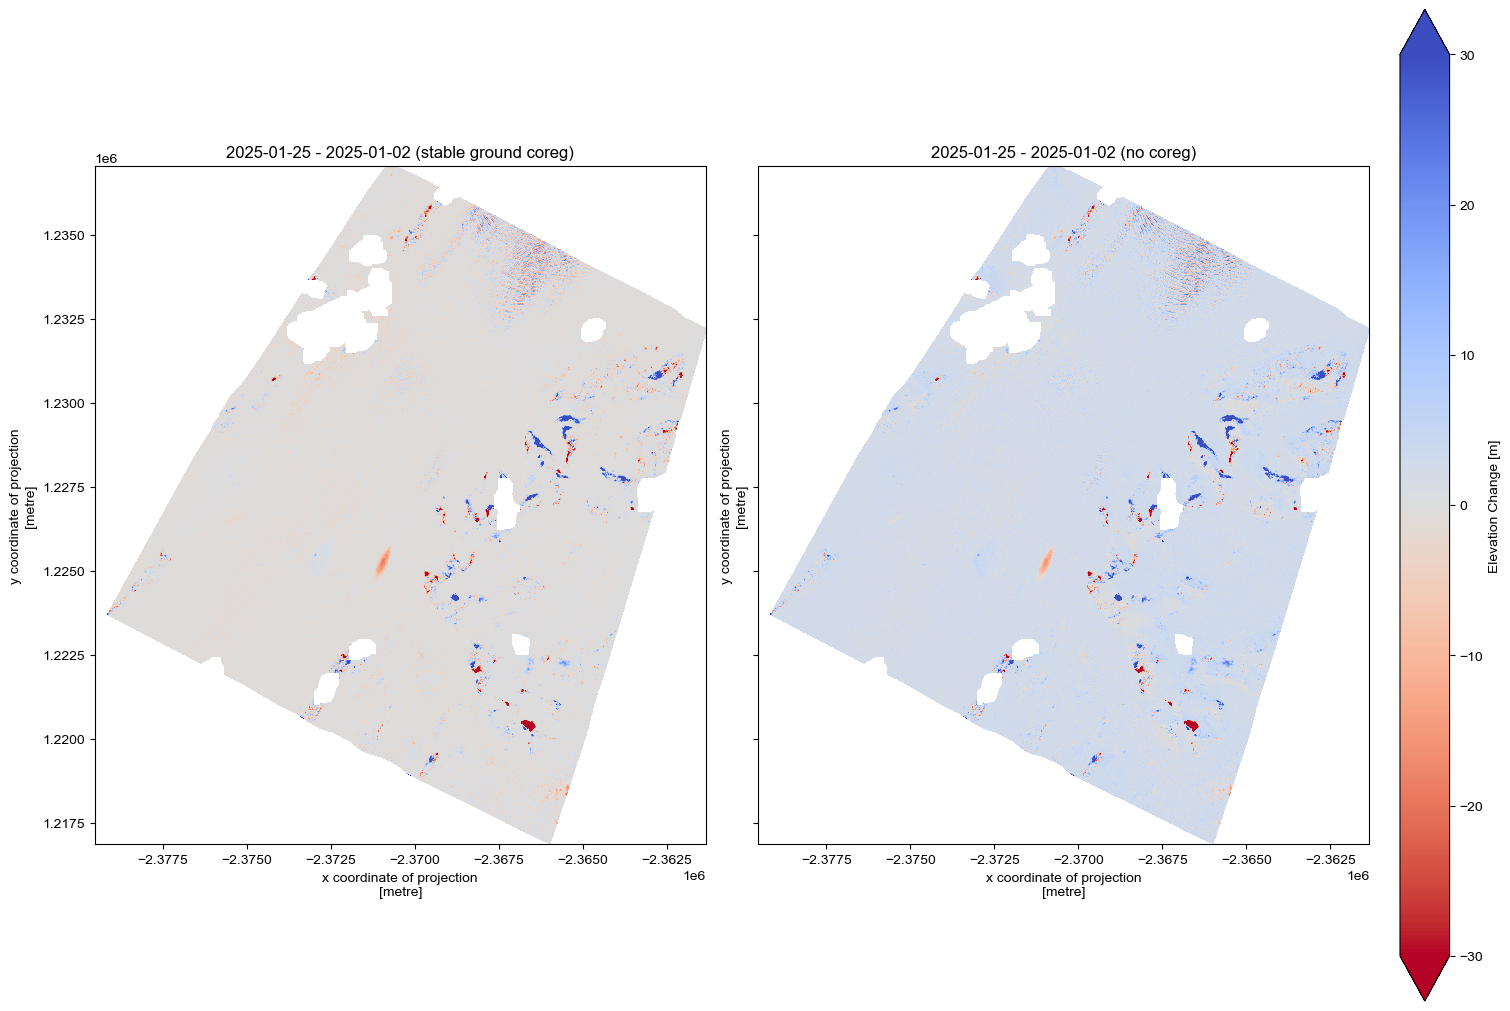

In [44]:
dz_coreg_bedrock = dem_2_coreg_bedrock - dem_1
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,10))

vrange = 30

ax = axes[0]
dz_coreg_bedrock.plot.imshow(ax=ax, cmap='coolwarm_r', vmin=-vrange, vmax=vrange, add_colorbar=False)
ax.set_title(f'{date_2} - {date_1} (stable ground coreg)')
ax.set_aspect('equal')

ax=axes[1]
dz_no_coreg.plot.imshow(ax=ax, cmap='coolwarm_r', vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'Elevation Change [m]'})
ax.set_title(f'{date_2} - {date_1} (no coreg)')
ax.set_aspect('equal')

## Save the results.
Save the difference DEM and the rock mask as geotiffs. 
The filenames include 'no_erode' to indicate that the masks were not eroded befire coregistration, as is explored next.

In [45]:
dz_coreg_bedrock.rio.to_raster('../../../remote sensing/worldview/coregistering/dz_coreg_bedrock_no_erode.tif')
bedrock_mask.rio.to_raster('../../../remote sensing/worldview/coregistering/bedrock_mask_no_erode.tif')

## Erode the rock mask then coregister the DEMs again
The rock mask overlapped ice in some places, so we try eroding it to various extents, then coregistering and differencing again. 

In [ ]:

def erode(da):

    # Apply erosion
    eroded = binary_erosion(da.data, iterations = 20)

    # Convert back to DataArray with same coords
    return xr.DataArray(eroded, dims=da.dims, coords=da.coords, attrs=da.attrs).astype(np.uint8)

# Erode the mask
eroded_mask = erode(bedrock_mask).astype(np.uint8)
eroded_mask.rio.to_raster('../../../remote sensing/worldview/coregistering/eroded_mask_iter_20.tif')

In [50]:
dem_2_coreg_eroded_bedrock, metadata_coreg_bedrock = dem_2.pdt.coregister_dems(
    dem_1,
    stable_mask=eroded_mask,
    return_stats=True,
)

Planimetric Correction Iteration 1
Offset (z,x,y): 0.000, 0.000, 0.000
RMSE = 6.670862197875977
Planimetric Correction Iteration 2
Offset (z,x,y): 2.416, 1.049, 1.686
Translating: 2.42 Z, 1.05 X, 1.69 Y
RMSE = 6.12545919418335
Planimetric Correction Iteration 3
Offset (z,x,y): 2.532, 1.348, 2.024
Translating: 2.53 Z, 1.35 X, 2.02 Y
RMSE = 6.124336242675781
Planimetric Correction Iteration 4
Offset (z,x,y): 2.565, 1.414, 2.087
Translating: 2.57 Z, 1.41 X, 2.09 Y
RMSE = 6.123876571655273
RMSE step in this iteration (-0.00046) is above threshold (-0.001), stopping and returning values of prior iteration.
Final offset (z,x,y): 2.532, 1.348, 2.024
Final RMSE = 6.124336242675781


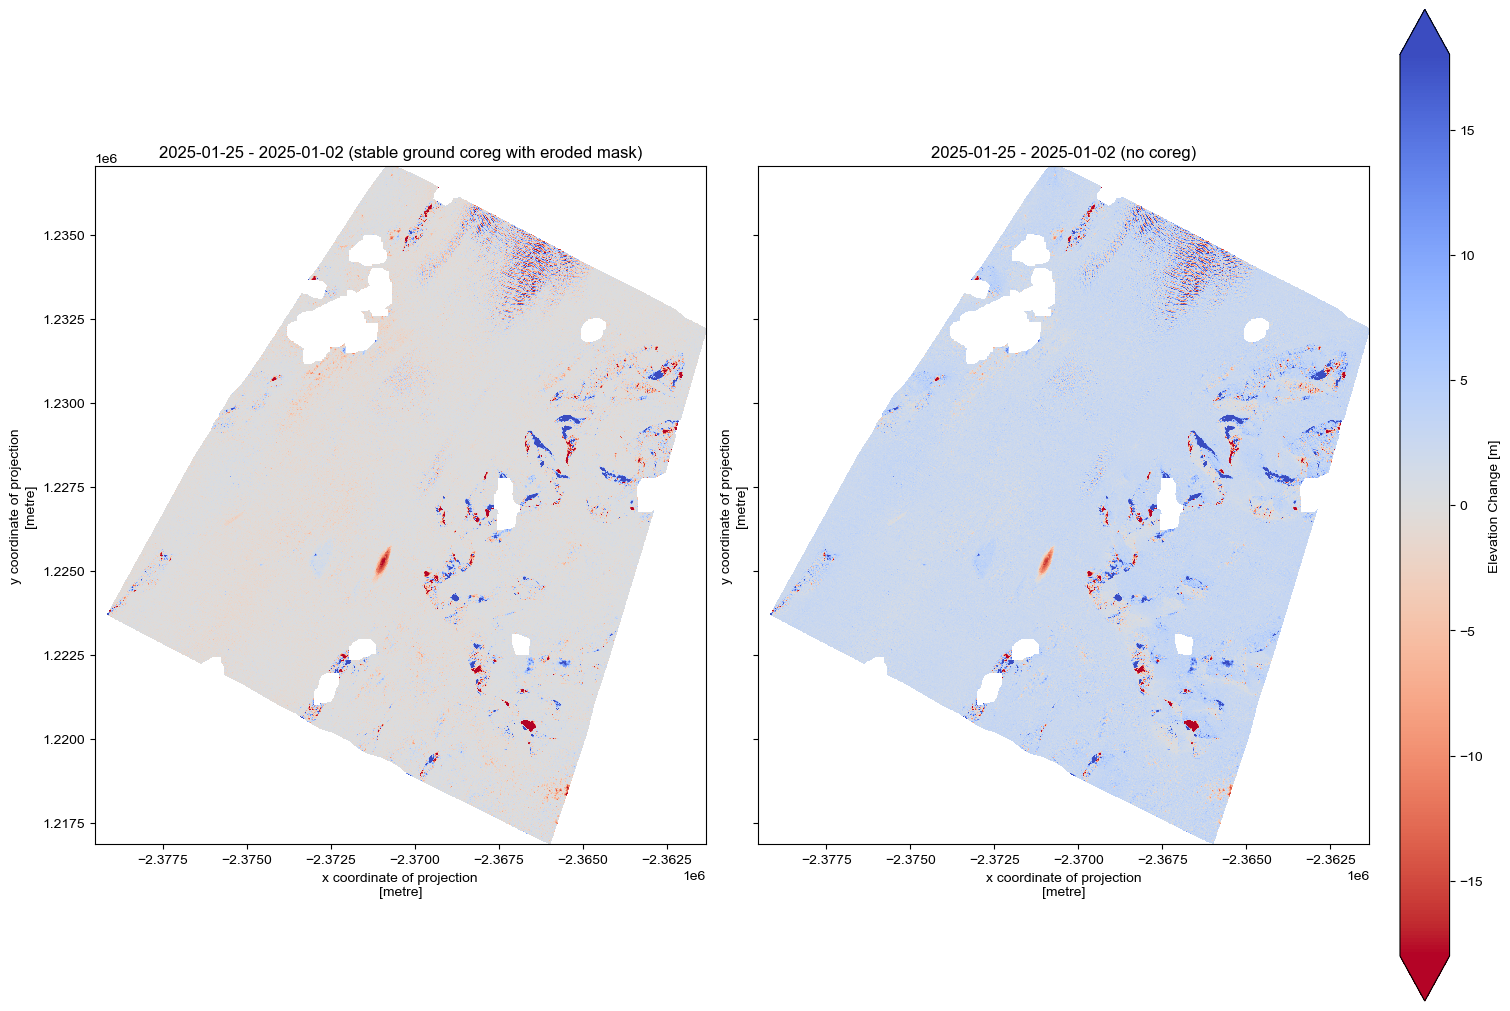

In [51]:
dz_coreg_eroded_bedrock = dem_2_coreg_eroded_bedrock - dem_1

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,10))

vrange = 18

ax = axes[0]
dz_coreg_eroded_bedrock.plot.imshow(ax=ax, cmap='coolwarm_r', vmin=-vrange, vmax=vrange, add_colorbar=False)
ax.set_title(f'{date_2} - {date_1} (stable ground coreg with eroded mask)')
ax.set_aspect('equal')

ax=axes[1]
dz_no_coreg.plot.imshow(ax=ax, cmap='coolwarm_r', vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'Elevation Change [m]'})
ax.set_title(f'{date_2} - {date_1} (no coreg)')
ax.set_aspect('equal')

In [ ]:
dz_coreg_eroded_bedrock.rio.to_raster('../../../remote sensing/worldview/coregistering/dz_coreg_eroded_bedrock_iter_20.tif')

## Put these steps in one function

In [35]:
def difference_dems(dem_name_1, 
                    dem_name_2,
                    dem_dir = "../../../remote sensing/worldview/6158_2025apr22_Kingslake_2024_25_DEMs/dem/",
                    vnumber = '_v040316',
                    SETM_prefix = 'SETSM_s2s041_',
                    erode_iterations = 20,
                    hillshade_z_factor = 2,
                    ):

    params = {'hillshade_z_factor': hillshade_z_factor, 'erode_iterations': erode_iterations}


    print('gathering file paths and dates')
    dem_1_fpath = os.path.join(dem_dir, dem_name_1 + vnumber, SETM_prefix + dem_name_1 + '_seg1_dem.tif')
    bitmask_1_fpath = os.path.join(dem_dir, dem_name_1 + vnumber, SETM_prefix + dem_name_1 + '_seg1_bitmask.tif')
    dem_1 = pdt.load.from_fpath(dem_1_fpath,  bitmask_fpath=bitmask_1_fpath)
    dem_2_fpath = os.path.join(dem_dir, dem_name_2 + vnumber, SETM_prefix + dem_name_2 + '_seg1_dem.tif')
    bitmask_2_fpath = os.path.join(dem_dir, dem_name_2 + vnumber, SETM_prefix + dem_name_2 + '_seg1_bitmask.tif')
    dem_2 = pdt.load.from_fpath(dem_2_fpath, bitmask_fpath=bitmask_2_fpath)

    def get_date(fn):
        # get the filename without the extension
        filename = os.path.basename(fn)
        # split the filename into parts
        parts = filename.split('_')
        # get the date part (the 4th part in this case)
        date_part = parts[3]
        # format the date part as YYYYMMDD
        date = f"{date_part[:4]}-{date_part[4:6]}-{date_part[6:]}"
        return date
    date_1 = get_date(dem_1_fpath)
    date_2 = get_date(dem_2_fpath)
    
    dz_no_coreg = dem_2 - dem_1
    bounds = dz_no_coreg.rio.bounds()

    print('loading dems')
    dem_1 = pdt.load.from_fpath(dem_1_fpath, bounds=bounds, pad=True, bitmask_fpath=bitmask_1_fpath, chunks=True).rename('dem_1_' + date_1)
    dem_2 = pdt.load.from_fpath(dem_2_fpath, bounds=bounds, pad=True, bitmask_fpath=bitmask_2_fpath, chunks=True).rename('dem_2_not_coreg_' + date_2)

    dem_1.attrs['description'] = 'DEM 1'
    dem_2.attrs['description'] = 'DEM 2 not coregistered'
    dem_1.attrs['date'] = date_1
    dem_2.attrs['date'] = date_2
    dem_1.attrs['dem_name'] = dem_name_1
    dem_2.attrs['dem_name'] = dem_name_2
    dem_1.attrs['dem_path'] = dem_1_fpath
    dem_2.attrs['dem_path'] = dem_2_fpath

    bedrock_mask=pdt.data.bedrock_mask_from_vector('/Users/jkingslake/Documents/data/quantarctica/Quantarctica3/Geology/ADD/ADD_RockOutcrops_Landsat8.shp', dem_1)

    print('eroding bedrock mask')
    def erode(da):
        eroded = binary_erosion(da.data, iterations = erode_iterations)
        return xr.DataArray(eroded, dims=da.dims, coords=da.coords, attrs=da.attrs).astype(np.uint8)

    eroded_mask = erode(bedrock_mask).rename('eroded_bedrock_mask')
    eroded_mask.attrs['description'] = 'Bedrock mask produced by eroding a mask from Quantarctica: ADD_RockOutcrops_Landsat8.shp'
    eroded_mask.attrs['erode_iterations'] = erode_iterations

    print('coregistering dem_2 to dem_1')
    dem_2_coreg, metadata_coreg_bedrock = dem_2.pdt.coregister_dems(
                                                            dem_1,
                                                            stable_mask=eroded_mask,
                                                            return_stats=True)
    dem_2_coreg = dem_2_coreg.rename('dem_2_' + date_2)
    dem_2_coreg.attrs['coreg_metadata'] = metadata_coreg_bedrock
    
    print('computing elevation change')
    dH =  (dem_2_coreg - dem_1).rename('dH')
    dH.attrs['units'] = 'm'
    dH.attrs['description'] = 'Elevation change between dem_2 and dem_1, coregistered to dem_1'

    # compute hillshade
    print('computing hillshade')
    hillshade_1 = dem_1.pdt.terrain('hillshade', hillshade_multidirectional=True, hillshade_z_factor=hillshade_z_factor).rename('hillshade_1_' + date_1)
    hillshade_2 = dem_2_coreg.pdt.terrain('hillshade', hillshade_multidirectional=True, hillshade_z_factor=hillshade_z_factor).rename('hillshade_2_' + date_2)


    hillshade_1.attrs['description'] = 'Hillshade of dem_1'
    hillshade_2.attrs['description'] = 'Hillshade of dem_2 coregistered to dem_1'
    hillshade_1.attrs['hillshade_z_factor'] = hillshade_z_factor
    hillshade_2.attrs['hillshade_z_factor'] = hillshade_z_factor
    hillshade_1.attrs['hillshade_multidirectional'] = True
    hillshade_2.attrs['hillshade_multidirectional'] = True
    
    out =  xr.merge([dem_2_coreg, dem_1, dH, eroded_mask, hillshade_1, hillshade_2])
    out.attrs['coreg_metadata'] = metadata_coreg_bedrock
    out.attrs['parameters'] = params

    return out

In [41]:
dem_names[2]

'WV03_20250125_10400100A1848B00_10400100A1BD5000_2m'

In [42]:
outputs = difference_dems('WV02_20250102_103001010BAF5D00_103001010C7CFB00_2m', 
                        'WV03_20250125_10400100A1848B00_10400100A1BD5000_2m')
#dz.plot.imshow(cmap='coolwarm_r', vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'Elevation Change [m]'})

gathering file paths and dates
loading dems
eroding bedrock mask
coregistering dem_2 to dem_1
Planimetric Correction Iteration 1
Offset (z,x,y): 0.000, 0.000, 0.000
RMSE = 6.670862197875977
Planimetric Correction Iteration 2
Offset (z,x,y): 2.416, 1.049, 1.686
Translating: 2.42 Z, 1.05 X, 1.69 Y
RMSE = 6.12545919418335
Planimetric Correction Iteration 3
Offset (z,x,y): 2.532, 1.348, 2.024
Translating: 2.53 Z, 1.35 X, 2.02 Y
RMSE = 6.124336242675781
Planimetric Correction Iteration 4
Offset (z,x,y): 2.565, 1.414, 2.087
Translating: 2.57 Z, 1.41 X, 2.09 Y
RMSE = 6.123876571655273
RMSE step in this iteration (-0.00046) is above threshold (-0.001), stopping and returning values of prior iteration.
Final offset (z,x,y): 2.532, 1.348, 2.024
Final RMSE = 6.124336242675781
computing elevation change
computing hillshade


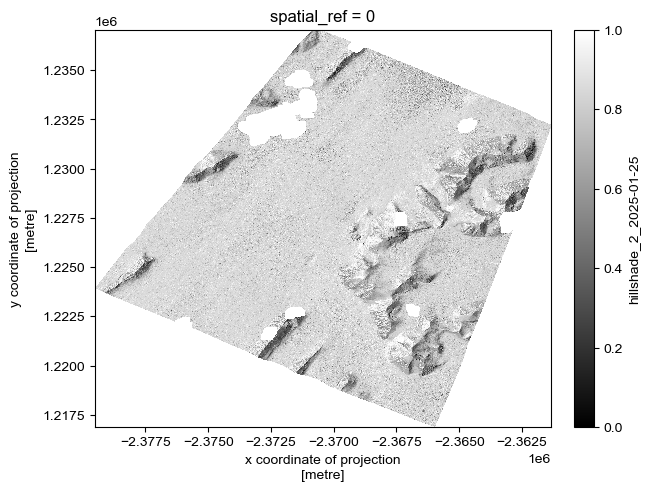

In [48]:
outputs['hillshade_2_2025-01-25'].plot.imshow(cmap='gray')

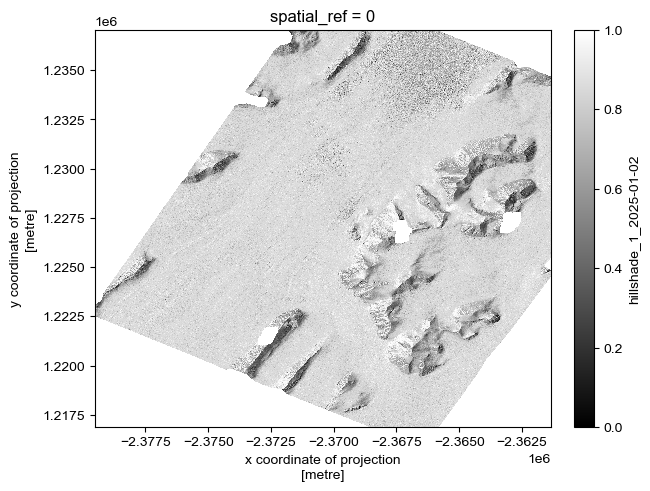

In [50]:
outputs['hillshade_1_2025-01-02'].plot.imshow(cmap='gray')

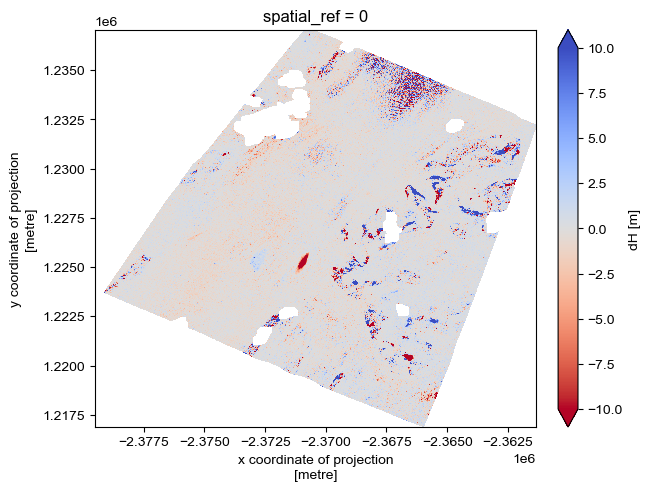

In [51]:
vrange=10
outputs.dH.plot.imshow(cmap='coolwarm_r', vmin=-vrange, vmax=vrange)

In [ ]:
dz = difference_dems('WV02_20250102_103001010BAF5D00_103001010C7CFB00_2m', 
                        'WV01_20250220_102001010B8E9300_102001010C0E9B00_2m')
dz.plot.imshow(cmap='coolwarm_r', vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'Elevation Change [m]'})
dz.rio.to_raster('../../../remote sensing/worldview/coregistering/dz_coreg_eroded_bedrock_iter_20_20250220-20250102.tif')

## Some approaches to masking that did not work:
(1) using bedmachine
(2) using icesat2

In [ ]:
bm_fpath = "/Users/jkingslake/Documents/data/bedmachine-v3/BedMachineAntarctica-v3.nc"

In [ ]:
bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bm_fpath, dem_1)
bedrock_mask.plot.imshow(cmap='gray', alpha=0.5, add_colorbar=False)

/Users/jkingslake/.local/share/mamba/envs/pdem_tools/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/jkingslake/.local/share/mamba/envs/pdem_tools/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/Users/jkingslake/.local/share/mamba/envs/pdem_tools/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/jkingslake/.local/share/mamba/envs/pdem_tools/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarn

ValueError: Must pass either crs or epsg.

In [ ]:
is2points_1 = pdt.data.icesat2_atl06(dem_1, date_1)

Querying points within 7 days... No points found intersecting. Expanding temporal search.
Querying points within 14 days... No points found intersecting. Expanding temporal search.
Querying points within 28 days... No points found intersecting. Expanding temporal search.
Querying points within 45 days... No points found intersecting. 

/Users/jkingslake/.local/share/mamba/envs/pdem_tools/lib/python3.13/site-packages/pdemtools/data.py:359: UserWarning: Returning GeoDataFrame with number of points below minimum threshold.
  warn("Returning GeoDataFrame with number of points below minimum threshold.")
